## Chapter 5: Transfer Learning for Image Classification
- Transfer learning is a technique where we transfer the leearning of the model on a generic dataset to the specific dataset of interest.  
- Pre-trained models are used to perform transfer learning and are trained on millions of images (based on generic dataset) and those pre-trained models are fine tuned to our dataset of interest
- there are two fundamental familes for transfer learning, VGG architecture and ResNet Architecture.  
- We will apply the two architectures to age and gender classification where we will learn about optimizing over both cross-entropy and using leveraging neural networks to generate multiple (136 instead of 1 prediction) continuous outputs in a single prediction

## Introduction to Transfer Learning
- knowledge gained from one task is used to solve similar task
- example, a model trained on millions of images that spans thousands of classes of objects (not just cats and dogs).   The various filters (kernels) of the model would activate  for a wide variety of shapes, colors and textures within the images.  
- These filters can be reused to learn features on a new set of images.  Post learning the features, they can be connected to a hidden layer prior to the final classification layer for customing on the new data
- ImageNet is a competition hosted to classify approximiately 14 million images into 1000 differentn classes.  It has a variety of classes in its dataset like Indian Elephant, lionfish, hard disk, hair spray etc
- The Deep Neural Network architectures we will go through in this chapter have been trained on the ImageNet dataset.  The Model is very deep in order to capture as much information as possible(in order to capture variety and the volume of objects that are to be classified by ImageNet, )

## Example of Transfer Learning
- Suppose we have images of a road, trying to classify them in terms of objects they contain.  
- Building a model from scratch might result in sub-optimal results as number of images could be insufficient to learn various variations within the dataset
- A pre-trained model trained on ImageNet comes in handy in such a scenario.  
- The model would have already learned a lot about traffic related classes like cars, roads, trees, humans during training on the large ImageNet dataset
- Hence leveraging the already trained model would result in faster and more accurate training as the model already knows the generic shapes and now has to fit them for specific images.  

## Steps in Transfer Learning
1. Normalize input images with the same mean and standard deviation that was used during the training process of pre-trained model
2. Fetch the pre-trained model's architecture.  Fetch the weights for this architecture that represents the estimate for its historical training process on large images
3. Discard the last few layers of the pre-trained model
4. Connect truncated pre-trained model to a freshly initialized layer where weights are randomly initialized.  Ensure the output of the last layer has as many neurons as the classes/outputs we would want to predict.  
5. Ensure the weights of the pre-trained model is not trainable (they should be frozen during back prop), but that the weights of newly initialized layer and the weights connecting it to the output layer are trainable
6. Update trainable parameters over increasing epochs to fit a model

Summary: We only learn the weights of the lower layers and not the weights of the pre-trained model as we leverage those weights to predict on new smaller dataset

## VGG16 (Visual Geometry Group) Architecture
- based out of University of Oxford
- 16 stands for number of layers in the model
- model is trained to classify objects in the ImageNet Competition and stood as as the runner up architecture in 2014.  
- We can also use GoogleNet for transfer learning


In [3]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F

from torchsummary import summary
from torchvision import transforms, models, datasets

device = 'mps'

model = models.vgg16(pretrained=True).to(device)

/Users/rajmani/Documents/research/Home/python/computer-vision/py_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rajmani/Documents/research/Home/python/computer-vision/py_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(model, torch.zeros(1, 3, 224, 224));

In [ ]:
model.classifier

In [ ]:
model

- Note that there are 3 submodules in the model: features, avgpol and classifier.  
- We would need to freeze the features and avgpool modules.  Delete the classifier module and create a new one in its place that will predict the required number of classes corresponding to our dataset (instead of existing 1000 classes)
- lets see how the VG16 model is used in practice using the cats and dogs dataset which contains 500 imaegs in each class for training

In [4]:
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import cv2, glob, numpy as np, pandas as pd
import random

img_height, img_width = 224, 224

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((img_height, img_width)),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

class CatsDogs(Dataset):
    def __init__(self, folder, transform=None):
        cats = glob.glob(folder + "/cats/*.jpg")
        dogs = glob.glob(folder + "/dogs/*.jpg")
        self.file_list = cats[:500] + dogs[:500]
        random.shuffle(self.file_list)
        self.labels = [path.split("/")[-1].startswith("dog") for path in self.file_list]
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(self.file_list[idx])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[idx]
        return img.to("mps"), torch.tensor([label], dtype=torch.float32).to("mps")

- when leveraging pretrained models, its important to resize, permute and normalize images (as appropriate for that pretrained model)
where images are first scaled to a value between 0 and 1 across the 3 channels and then normalized to a mean of [0.485, 0.456, 0.506] and standard deviation of [0.229, 0.224, 0.225] across the RGB channels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


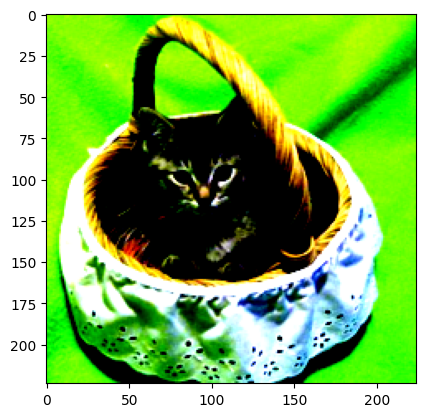

In [21]:
import os
import matplotlib.pyplot as plt
folder = os.path.join(os.getcwd(), 'datasets', 'cat_and_dog_images')
train_folder = os.path.join(folder, 'training_set')
test_folder = os.path.join(folder, 'test_set')
data = CatsDogs(train_folder, transform=transform)
img, label = data[200]
plt.imshow((img).permute(1, 2, 0).cpu())

In [6]:
def get_model():
    model = models.vgg16(pretrained=True)
    # freeze all parameters in the model downloaded previously
    # this will freeze all parameter updates during backpropagation
    for param in model.parameters():
        param.requires_grad = False
    # output is batch_size x 512 x k x k
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    # connect the output from previous avgpool layer with classifier layer
    model.classifier = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, 1),
                                     nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [7]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1, 3, 224, 224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

- notice that number of trainable parameters is only 65k out of 14 million parameters since we froze the features module and overwritten the avgpool and classifier modules.  
- Now only the classsifier module will have weights that will be learned
- total parameters for sequential is 128*512 + 128 = 65,664 parameters

In [8]:
def train_model(x, y, model, opt, loss_fn):
    model.train()
    # 1. Generate predictions
    pred = model(x)
    # 2. Calculate loss
    batch_loss = loss_fn(pred, y)
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train = CatsDogs(train_folder, transform=transform)
    train_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogs(test_folder, transform)
    val_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    return train_dl, val_dl

In [ ]:
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

num_epochs = 5
model = model.to("mps") # for some reason this is needed for it to train properly
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for x_batch, y_batch in train_dl:
        batch_loss = train_model(x_batch, y_batch, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x_batch, y_batch in train_dl:
        is_correct = accuracy(x_batch, y_batch, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for x_batch, y_batch in val_dl:
        val_is_correct = accuracy(x_batch, y_batch, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

In [ ]:

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

- Note that we are able to get to 98% accuracy within the first epoch on a small dataset (1000 images with 500 images in each class)
- In addition to VGG16, we have VGG11 and VGG19 pre-trained architecture
- VGG-19 has better accuracy slightly over VG16 and VG11 has lower accuracy than VG16.  So this indicates that as we increase the number of layers, accuracy increases
- So one way to increase accuracy of a deep learning model is to keep adding more and more layers and then fine tune the dataset on the validation set for better results (to avoid overfitting)
- but we can't keep adding more and more layers to get better accuracy since we would need to train more parameters, vanishing gradient problems arise and there is too much information modification as deeper layers
- Hence __ResNet__ Architecture comes to the rescue over here

## Understanding ResNet Architecture
- in deep learning models, there are two problems.  
- In forward propagation, last few layers have almost no information about what the original image was.  
- In back prop, first few layers near the input hardly get any gradient updates due to vanishing gradients ( in other words, they are almost zero). 
- To solve both these issues, residual Networks (ResNet) use a highway-like connection that transfers raw information from previous few layers to the later layers
- In theory, even the last layer has entire information from original image due to this highway network
- Also, due to skipping layers, backward gradients will flow freely to the initial layers with little modification
- The term residual in the residual network is the additional information that the model is expected to learn from previous layer that needs to be passed on the next layer
- In ResNet, we have the resnet block, which takes an input $x$ and compute a value $F(x)$ which represents the linear transformation with weights.  and finally compute $z = F(x) + x$ and then compute the activation $y = \sigma(z)$
- So far, we h ave been using standard layers that performed either a linear or convolution transformations $F(x)$ along with some non linear activation that destroyed the original input.  
- Now, we can perform the same non linear transformation with the weights, but also add the input to the final transformation so that the network focuses on learning the correct transformation for the task rather than trying to remember what the input is

In [9]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ResNetBlock, self).__init__()
        # padding is needed as we need to sum up the output of the network with input
        # and since pooling reduces dimension, we need to retain the dimension.  
        padding = kernel_size - 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding),
            nn.ReLU()
        )
        def forward(self, x):
            x = self.conv(x) + x
            return x

- Note that in ResNet18 which is a pre-trained resiual block based network.  
- There are 18 layers in this network.  Skip connections are made after every two layers, i.e input at layer $l$ is passed to output as layer $l + 2$, that is, 

$z_{l+2} = F_{l+2}(x_{l+1}) + x_{l}$

and 

$a_{l+2} = \sigma(z_{l+2})$

- Lets build a architecture based on ResNet18 architecture to classify dogs and cats just like we did for VGG16.  Majority of the steps are the same as for VGG16

In [10]:
model = models.resnet18(pretrained=True)
summary(model, torch.zeros(1, 3, 224, 224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]          --
|

/Users/rajmani/Documents/research/Home/python/computer-vision/py_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [12]:
def get_model():
    model = models.resnet18(pretrained=True)
    # freeze all parameters in the model downloaded previously
    # this will freeze all parameter updates during backpropagation
    for param in model.parameters():
        param.requires_grad = False
    # output is batch_size x 512 x k x k
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    # connect the output from previous avgpool layer with classifier layer
    model.fc = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512, 128),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(128, 1),
                                     nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [13]:
train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

num_epochs = 5
model = model.to("mps") # for some reason this is needed for it to train properly
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for x_batch, y_batch in train_dl:
        batch_loss = train_model(x_batch, y_batch, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x_batch, y_batch in train_dl:
        is_correct = accuracy(x_batch, y_batch, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for x_batch, y_batch in val_dl:
        val_is_correct = accuracy(x_batch, y_batch, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


In [ ]:

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

- Besides VGG and ResNet, other prominent pretrained models are inception, mobilenet, densetnet and squeezenet
- lets now focus on leveraging pre-trained models to solve multi-regression (facial key point detection) and multi-task learning, prediction of multiple items in a single shot - age, estimation and gender classification

## Facial KeyPoint Detection (Can skip for now)

__Task__

We need to predict key points present on an image of a face, example the location of eyes, nose and chin

__Note__

Facial keypoints denote the markings of various key points on the image that contains a face
- But images can be of different shapes.  Hence we need to adjust the location of key points while adjusting the image size to bring them all to a standard size
- Facial key points are similar to points on a scatter plot, but scattered based on certain pattern
- So values are between 0 and 224 if image is reshaped to 224x224x3
- Normalize the dependent variable (location of facial keypoints) as per the size of the image.  Key point values are always between 0 and 1 if we consider their location relative to image dimensions
- Since dependent variable values are always between 0 and 1, we can use sigmoid layer at hte end to fetch values that will be between 0 and 1

__Pipeline for solving the Facial Keypoint Detection Problem__
1. Import relevant packages
2. Import data
3. Define a class that prepares the dataset
    - Ensure appropriate preprocessing is done on input images to perform transfer learning
    - Ensure the location of key points is processed in such a way that we fetch their relative position with respect to the processed image
4. Define a model, loss function and optimizer
    - Loss function is the mean absolute error as output is continuous and between 0 and 1
5. Train the model over increasing epochs


In [8]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset, DataLoader, Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'mps'

path = os.path.join(os.getcwd(), 'datasets', 'P1_Facial_keypoints', 'data')
all_img_paths = glob.glob(os.path.join(path, 'training', '*.jpg'))


#

In [9]:
path

'/Users/rajmani/Documents/research/Home/python/computer-vision/datasets/P1_Facial_keypoints/data'

In [10]:
df = pd.read_csv(path + '/training_frames_keypoints.csv')

In [11]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


- column one represents name of the image.  Even columns represents x axis value corresponding to each of the 68 key points in the face
- odd column represents the y axis value corresponding to each of the 68 keypoints.  

In [12]:
class FacesData(Dataset):
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        img_path = path + '/training/' + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix, 1:].tolist())
        kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y 
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    
    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)
    
    def load_img(self, ix):
        img_path = path + '/training/' + self.df.iloc[ix, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
        img = cv2.resize(img, (224,224))
        return img
    



In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
nn.Conv2d

In [19]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    # overwrite and unfreeze the parameters of last two layer of the model
        model.avgpool = nn.Sequential(nn.Conv2d(512, 512, 3), nn.MaxPool2d(2), nn.Flatten())
        model.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 136),
            nn.Sigmoid()
        
        )
        criterion = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        return model.to(device), criterion, optimizer

- note that the last layer of the model above is a sigmoid function that returns a value between 0 and 1.  This is because keypoint locations are a fraction of the original image's dimensions, hence exepcted output is always going to be between 0 and 1
- also notice we are using L1Loss, which is mean absolute loss since we are performing mean absolute error reduction on the prediction of hte location of facial key points, which is predicted to be a percentage of image's width and height.  

In [20]:
model, criterion, optimizer = get_model()

/Users/rajmani/Documents/research/Home/python/computer-vision/py_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rajmani/Documents/research/Home/python/computer-vision/py_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
def train_model(img, kps, model, opt, loss_fn):
    model.train()
    # 1. Generate predictions
    pred = model(img.to(device))
    # 2. Calculate loss
    batch_loss = loss_fn(pred, kps.to(device))
    # 3. Compute gradients
    batch_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    # 5. Reset gradients to zero for next pass
    opt.zero_grad()
    return batch_loss.item()

In [22]:
def validate_batch(img, kps, model, criterion):
    model.eval()
    with torch.no_grad():
        _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f" epoch {epoch + 1}: 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img, kps) in enumerate(train_loader):
        loss = train_model(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss
    epoch_train_loss /= (ix + 1)

    for ix, (img, kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss
    epoch_test_loss /= (ix + 1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1: 50
 epoch 2: 50
 epoch 3: 50
 epoch 4: 50
 epoch 5: 50
 epoch 6: 50
 epoch 7: 50
 epoch 8: 50
 epoch 9: 50
 epoch 10: 50
 epoch 11: 50
 epoch 12: 50
 epoch 13: 50
 epoch 14: 50
 epoch 15: 50
 epoch 16: 50
 epoch 17: 50
 epoch 18: 50
 epoch 19: 50
 epoch 20: 50
 epoch 21: 50
 epoch 22: 50
 epoch 23: 50
 epoch 24: 50
 epoch 25: 50
 epoch 26: 50
 epoch 27: 50
 epoch 28: 50
 epoch 29: 50
 epoch 30: 50
 epoch 31: 50
 epoch 32: 50
 epoch 33: 50
 epoch 34: 50
 epoch 35: 50
 epoch 36: 50
 epoch 37: 50
 epoch 38: 50
 epoch 39: 50
 epoch 40: 50
 epoch 41: 50
 epoch 42: 50
 epoch 43: 50
 epoch 44: 50
 epoch 45: 50
 epoch 46: 50
 epoch 47: 50
 epoch 48: 50
 epoch 49: 50
 epoch 50: 50


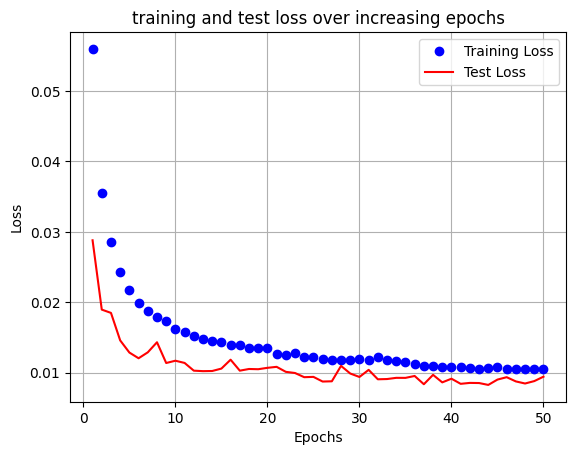

In [29]:
epochs = np.arange(50) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker

plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, [val.cpu().item() for val in test_loss], 'r', label='Test Loss')
plt.title("training and test loss over increasing epochs");
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend()
plt.grid()

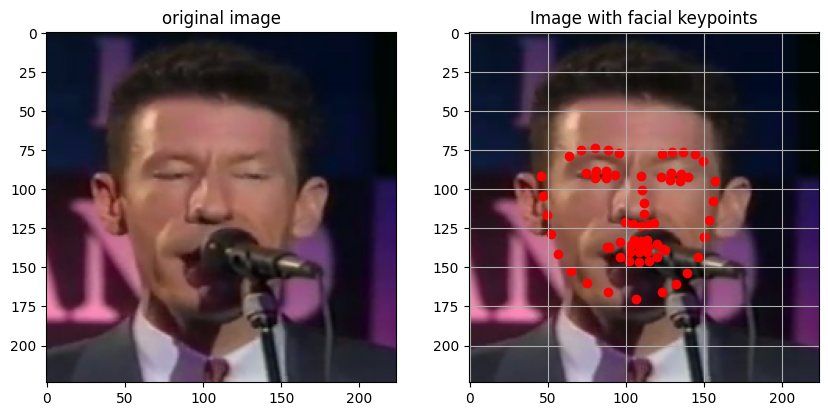

In [36]:
0
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("original image")
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title("Image with facial keypoints")
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid()


### Multi-task Learning - Implementing Age and estimation and gender classification
- branch of research where a single few points are used to predict several different but ultimately connected outputs.  
- Example, in self driving car, model needs to identify obstacles, plan routes, give the right amount of throttle/brake and steering.  
- It needs to perform the above actions in a split second.  
- We can train a neural network to estimate the age of a person given the image or predict gender when given the image, as separate tasks.  
- Can we combine the above two tasks and hence predict the age and the gender given the image as the same image is used for both predictions? 

- We can predict both the attributes, continuous and categorical both in a single forward pass

The strategy we will adopt is as follows:
1. Import Relevant packages
2. fetch teh dataset that contains images of persons, their gender and age information
3. Create training set andn test datasets by performing appropriate pre-processing 
4. Build a model where following applies:
    - All layers of the model remain similar to the models we have built so far, except the last part
    - in the last part, create two separate layers branching out from preceding layer where one layer does the age estimation
    - and second layer does the gender classification
    - ensure we have two different loss functions, one for binary cross entropy loss and mse for age estimation
    - take the total of age estimation loss and gender classification loss
    - Minimize the over loss by performing backpropagation that optimizes weight values
5. Train the model and predict on new images

1. Import the Relevant Packages

In [1]:
import torch
import numpy as np, cv2, pandas as pd, glob, time 
import matplotlib.pyplot as plt 
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets

2. Fetch the dataset

In [2]:
path = os.path.join(os.getcwd(), 'datasets')
fairface_folder = os.path.join(path, 'FairFace')
path_to_train_csv = os.path.join(fairface_folder, 'fairface_label_train.csv')
path_to_val_csv =  os.path.join(fairface_folder, 'fairface_label_val.csv')
train_df = pd.read_csv(path_to_train_csv)
val_df = pd.read_csv(path_to_val_csv)

In [3]:
train_df.iloc[0].age.split("-")[0]

'50'

4. Build the GenderAgeClass that takes filename as input and returns corresponding image, gender and scaled age
- we scale age as its a continuous number and scaling is good as it helps avoid vanishing gradients (building a dep neural network with pytorch talks about scaling)

In [15]:
IMAGE_SIZE = 224
class GenderAge(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = fairface_folder + '/' + f.file
        gender = f.gender == 'Female'
        age = f.age
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gender
    
    def preprocess_image(self, img):
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img / 255.)
        return img[None]
    
    def collate_fn(self, batch):
        'preprocess images, age and genders'
        images = []
        ages = []
        genders = []
        for img, age, gender in batch:
            img = self.preprocess_image(img)
            images.append(img)
            if '-' in age:
                age = age.split("-")[0]
            else:
                age = '70'
            ages.append(float(int(age)/80.))
            genders.append(float(gender))
        
        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        images = torch.cat(images).to(device)
        return images, ages, genders


In [16]:
train_set = GenderAge(train_df, transforms=transforms)
val_set = GenderAge(val_df, transforms=transforms)
device = 'mps'
train_dl = DataLoader(train_set, batch_size=32, collate_fn=train_set.collate_fn)
val_dl = DataLoader(val_set, batch_size=32, collate_fn=val_set.collate_fn)

In [17]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
    )
    # create two new branches of outputs
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU()
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
    
    model.classifier = ageGenderClassifier()
    age_criterion = nn.L1Loss()
    gender_criterion = nn.BCELoss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_functions, optimizer

In [18]:
model, criterion, optimizer = get_model()

/Users/rajmani/Documents/research/Home/python/computer-vision/py_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rajmani/Documents/research/Home/python/computer-vision/py_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- in preceding code, last layers have sigmoid activation since the age output is between 0 and 1 (since it has been scaled) and gender has sigmoid as output is either 0 or 1

In [19]:
def train_batch(data, model, opt, criteria):
    model.train()
    img, age, gender = data
    opt.zero_grad()
    # 1. Generate predictions
    pred_gender, pred_age = model(img)
    # 2. Calculate loss
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    # 3. Compute gradients
    total_loss = gender_loss + age_loss
    total_loss.backward()
    # 4. Update parameters using gradients
    opt.step()
    return total_loss.item()

def validate_batch(data, model, criteria):
    model.eval()
    img, age, gender = data
    
    with torch.no_grad():
        # 1. Generate predictions
        pred_gender, pred_age = model(img)
    # 2. Calculate loss
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss.item(), gender_acc, age_mae

In [20]:
# train the model over 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    print(f"epoch: {epoch + 1}")
    for ix, batch in enumerate(train_dl):
        loss = train_batch(batch, model, optimizer, criterion)

epoch: 1


epoch: 2
epoch: 3
epoch: 4
epoch: 5


- Make a prediction of age and gender on a random test image

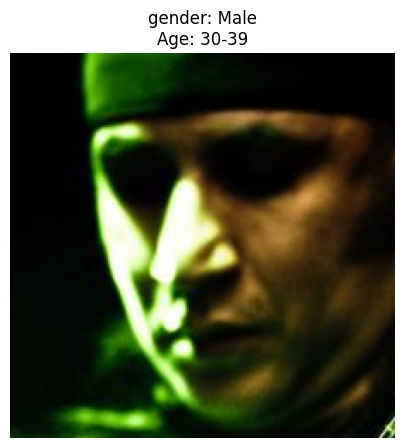

In [116]:
import torch_snippets as ts
idx = np.random.randint(0, 1000)
image, age, gender = val_set[idx]
gender = 'Female' if gender else 'Male'
ts.show(image, title=f'gender: {gender}\nAge: {age}', sz=5)

In [117]:
image = val_set.preprocess_image(image)

In [118]:
gender, age = model(image.to(device))
gender = gender.squeeze().item()
gender = 'Male' if gender < 0.5 else 'Female'
print(f'predicted gender: {gender}')
print(f'predicted age:  {int(age.item() * 80)}')

predicted gender: Male
predicted age:  30


In [87]:
age.item()

0.37896743416786194

## Introducing Torch Snippets Library
- read in the book

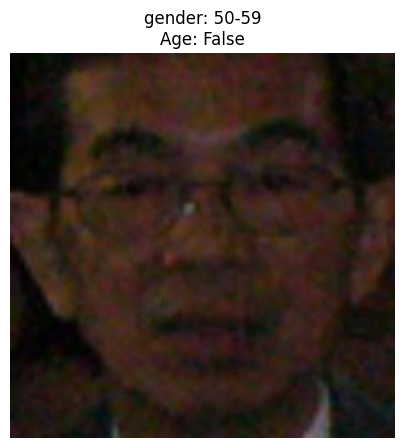

In [27]:
import torch_snippets as ts
im, gen, age = train_set[0]
ts.show(im, title=f'gender: {gen}\nAge: {age}', sz=5)

In [ ]:
ims, gens, ages = next(iter(train_dl))
ts.inspect(ims, gens, ages)